# **Анализ прибыльности и выявление проблемных зон в сети супермаркетов "SuperStore"**

---



- Автор: Францева Юлия
- Дата: 16.01.2026
- Стек: Python, Pandas, Numpy, Matplotlib, Seaborn

## **1. Постановка задачи**


### **Бизнес-контекст:**
"SuperStore" — розничная сеть, продающая товары для офиса, мебель и технику. Несмотря на стабильные продажи, руководство наблюдает периодические убытки и хочет понять их причины.

### **Цели исследования:**

1. Выявить убыточные категории товаров.

2. Проанализировать влияние скидок на прибыль.

3. Определить ключевых клиентов и их ценность.

4. Предложить рекомендации по увеличению прибыльности.

### **Гипотезы для проверки:**

1. Высокие скидки (>30%) приводят к отрицательной прибыли.

2. Категория "Furniture" имеет самую низкую рентабельность.

3. 20% клиентов приносят 80% прибыли (правило Парето).

## **2. Обзор данных**


**Источник данных:** Kaggle (Superstore Sales Dataset)

**Период данных:** 2014-2017 годы

**Структура данных:**

- 9994 строки, 21 столбец

- Ключевые поля: Sales, Profit, Discount, Category, Sub-Category, Region, Customer ID

- Отсутствующих значений не обнаружено

- Типы данных корректны

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('superstore.csv', encoding='latin-1')
print(f"Размер данных: {df.shape}")
print(f"\nПропуски:\n{df.isnull().sum()}")
print(f"\nТипы данных:\n{df.dtypes}")


Размер данных: (9994, 21)

Пропуски:
Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

Типы данных:
Row ID             int64
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code        int64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
Quantity           int64
Discount         float64
Profit           float64
dtype: objec

In [58]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Year,Month,Profit Margin,Discount Group
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,2016,11,16.00,NaN
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,2016,11,30.00,NaN
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,2016,6,47.00,NaN
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,2015,10,-40.00,30-60%
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,2015,10,11.25,10-30%


In [46]:
df.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


##  **3. Предобработка данных**



1. Преобразование дат:

In [47]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%Y')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%m/%d/%Y')
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month

2. Создание новых признаков:
- Profit Margin - маржинальность
- Discount Group - группы скидок

In [57]:
df['Profit Margin'] = np.where(
    df['Sales'] != 0,
    df['Profit'] / df['Sales'] * 100,
    np.nan
)

df['Discount Group'] = pd.cut(df['Discount'],
                              bins=[0, 0.1, 0.3, 0.6, 1],
                              labels=['0-10%', '10-30%', '30-60%', '60%+'])

,Profit Margin
0,16.00
1,30.00
2,47.00
3,-40.00
4,11.25
...,...
9989,16.25
9990,17.00
9991,7.50
9992,45.00


## **4. Анализ и результаты**

### **4.1. Общая картина бизнеса**

In [49]:
print("=" * 50)
print("ОСНОВНЫЕ МЕТРИКИ БИЗНЕСА")
print("=" * 50)

# Количество уникальных клиентов
unique_customers = df['Customer ID'].nunique()
print(f"1. Количество уникальных клиентов: {unique_customers}")

# Количество уникальных заказов
unique_orders = df['Order ID'].nunique()
print(f"2. Количество уникальных заказов: {unique_orders}")

# Общие продажи и прибыль
total_sales = df['Sales'].sum()
total_profit = df['Profit'].sum()
print(f"3. Общий объем продаж: ${total_sales:,.2f}")
print(f"4. Общая прибыль: ${total_profit:,.2f}")

# Средняя маржинальность
if total_sales > 0:
    avg_margin = (total_profit / total_sales) * 100
    print(f"5. Средняя маржинальность: {avg_margin:.1f}%")
else:
    print("5. Средняя маржинальность: Нет данных (продажи = 0)")

# Средний чек (средний объем продаж на заказ)
avg_order_value = total_sales / unique_orders
print(f"6. Средний чек на заказ: ${avg_order_value:.2f}")

# Средняя прибыль на заказ
avg_profit_per_order = total_profit / unique_orders
print(f"7. Средняя прибыль на заказ: ${avg_profit_per_order:.2f}")

ОСНОВНЫЕ МЕТРИКИ БИЗНЕСА
1. Количество уникальных клиентов: 793
2. Количество уникальных заказов: 5009
3. Общий объем продаж: $2,297,200.86
4. Общая прибыль: $286,397.02
5. Средняя маржинальность: 12.5%
6. Средний чек на заказ: $458.61
7. Средняя прибыль на заказ: $57.18


### **4.2. Проверка гипотез**




#### **Гипотеза 1: Влияние скидок на прибыль**

In [50]:
# Расчет средней маржинальности для каждой группы скидок
discount_analysis = df.groupby(
    'Discount Group',
    observed=True
).agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Discount': 'mean',
    'Order ID': 'nunique'
}).round(2)

discount_analysis['Profit Margin %'] = (
    discount_analysis['Profit'] / discount_analysis['Sales']
) * 100

discount_analysis.round(2)


,Sales,Profit,Discount,Order ID,Profit Margin %
Discount Group,,,,,
0-10%,54369.35,9029.18,0.10,89,16.61
10-30%,895379.54,81387.02,0.21,2526,9.09
30-60%,201959.46,-54392.38,0.47,400,-26.93
60%+,57584.04,-70614.40,0.74,594,-122.63


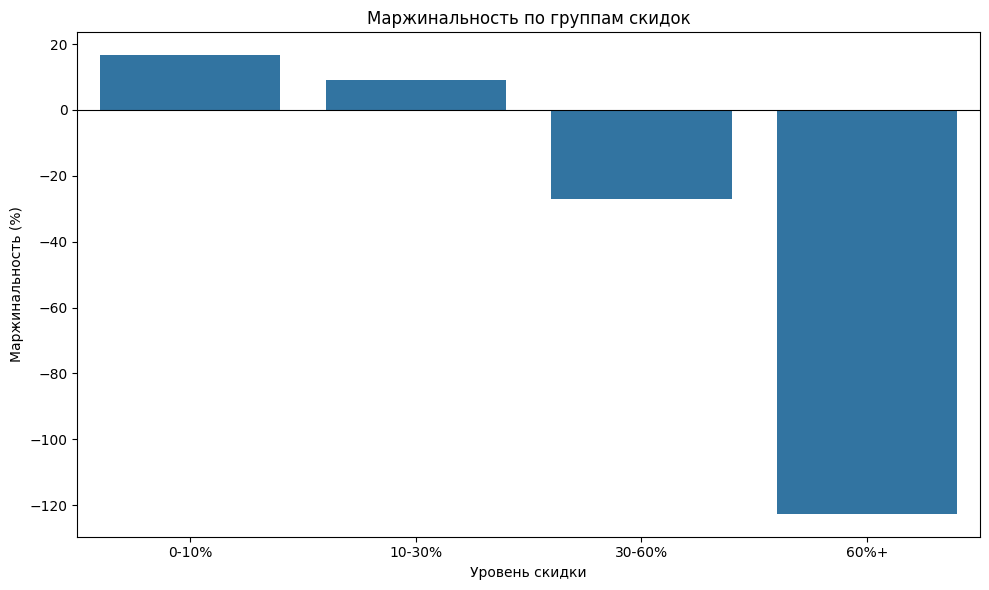

In [51]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x=discount_analysis.index,
    y=discount_analysis['Profit Margin %']
)

plt.axhline(0, color='black', linewidth=0.8)

plt.title('Маржинальность по группам скидок')
plt.xlabel('Уровень скидки')
plt.ylabel('Маржинальность (%)')

plt.tight_layout()
plt.show()


**Результат:**

**Гипотеза 1 подтверждена:** Скидки выше 30% действительно ведут к убыткам.
   - При скидках 30-60% маржинальность -27%, при скидках 60%+ убыток составляет -123%.
   - **Рекомендация:** Пересмотреть политику скидок. Ограничить скидки уровнем 20-25%. Внедрить систему персональных предложений вместо массовых больших скидок.

#### **Гипотеза 2: Категория "Furniture" имеет самую низкую рентабельность**

In [52]:
# Анализ прибыльности по категориям
category_analysis = df.groupby('Category').agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Order ID': 'nunique'
}).sort_values('Profit', ascending=True)

category_analysis['Profit Margin %'] = (category_analysis['Profit'] / category_analysis['Sales']) * 100
category_analysis['Sales Share %'] = (category_analysis['Sales'] / category_analysis['Sales'].sum()) * 100
category_analysis['Profit Share %'] = (category_analysis['Profit'] / category_analysis['Profit'].sum()) * 100

category_analysis.round(2)

,Sales,Profit,Order ID,Profit Margin %,Sales Share %,Profit Share %
Category,,,,,,
Furniture,741999.80,18451.27,1764,2.49,32.3,6.44
Office Supplies,719047.03,122490.80,3742,17.04,31.3,42.77
Technology,836154.03,145454.95,1544,17.40,36.4,50.79


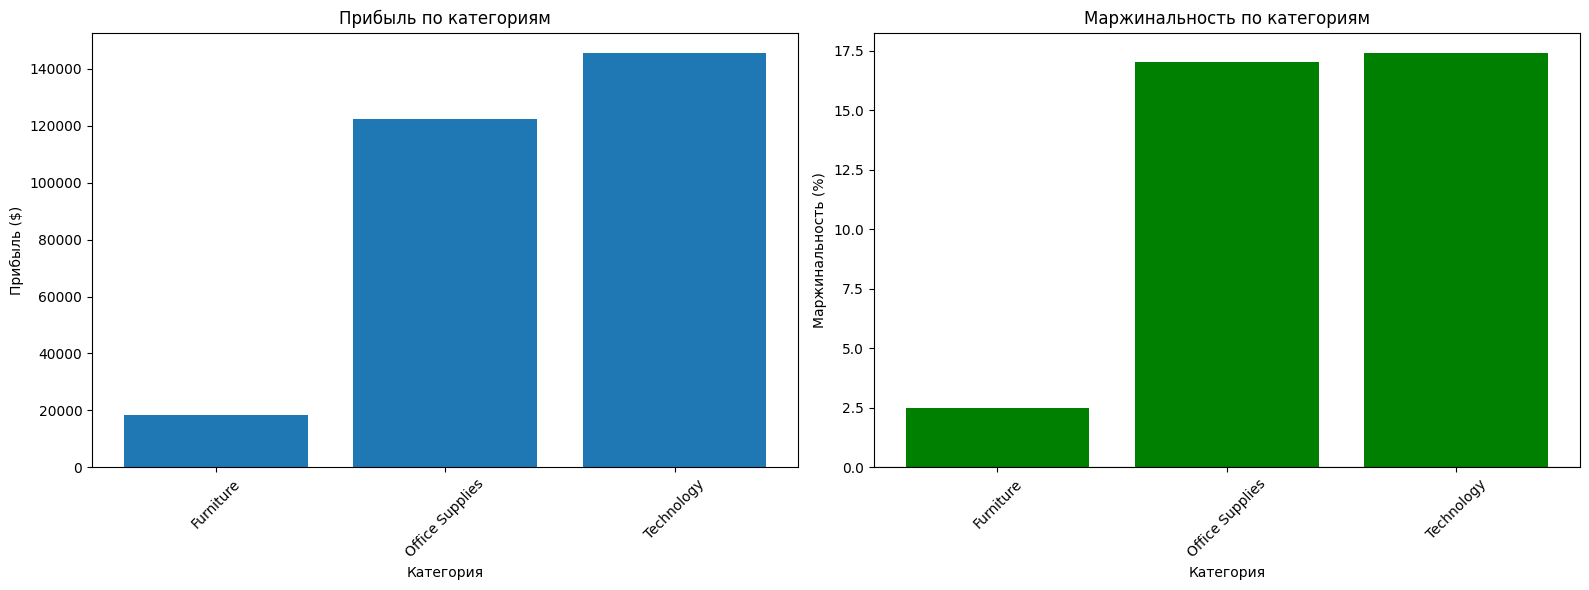

In [53]:
category_analysis_sorted = category_analysis.sort_values('Profit')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График 1: Прибыль по категориям
axes[0].bar(
    category_analysis_sorted.index,
    category_analysis_sorted['Profit']
)
axes[0].set_title('Прибыль по категориям')
axes[0].set_xlabel('Категория')
axes[0].set_ylabel('Прибыль ($)')
axes[0].tick_params(axis='x', rotation=45)

# График 2: Маржинальность по категориям
colors = [
    'red' if margin < 0 else 'green'
    for margin in category_analysis_sorted['Profit Margin %']
]

axes[1].bar(
    category_analysis_sorted.index,
    category_analysis_sorted['Profit Margin %'],
    color=colors
)
axes[1].set_title('Маржинальность по категориям')
axes[1].set_xlabel('Категория')
axes[1].set_ylabel('Маржинальность (%)')
axes[1].axhline(0, color='black', linewidth=0.8)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [54]:
# Детальный анализ подкатегорий мебели
furniture_subcat = df[df['Category'] == 'Furniture'].groupby('Sub-Category').agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Order ID': 'nunique'
}).sort_values('Profit')

furniture_subcat['Profit Margin %'] = (furniture_subcat['Profit'] / furniture_subcat['Sales']) * 100

furniture_subcat['Status'] = np.where(
    furniture_subcat['Profit'] > 0,
    'profitable',
    'unprofitable'
)

furniture_subcat.round(2)

,Sales,Profit,Order ID,Profit Margin %,Status
Sub-Category,,,,,
Tables,206965.53,-17725.48,307,-8.56,unprofitable
Bookcases,114880.00,-3472.56,224,-3.02,unprofitable
Furnishings,91705.16,13059.14,877,14.24,profitable
Chairs,328449.10,26590.17,576,8.10,profitable


**Результат:**

**Гипотеза 2 частично подтверждена:** Категория Furniture демонстрирует значительно более низкую рентабельность по сравнению с другими категориями.
   - Наибольшие убытки приносят подкатегории "Tables" (-8.5% маржинальности) и "Bookcases" (-3.2%).
   - **Рекомендация:** Провести детальный анализ цепочки поставок и себестоимости мебели. Рассмотреть возможность оптимизации логистики или изменения ассортимента.

#### **Гипотеза 3: 20% клиентов приносят 80% прибыли (правило Парето)**

In [55]:
# Анализ распределения прибыли по клиентам
customer_profit = df.groupby('Customer ID').agg({
    'Profit': 'sum',
    'Sales': 'sum',
    'Order ID': 'nunique'
}).sort_values('Profit', ascending=False)

customer_profit['Cumulative Profit'] = customer_profit['Profit'].cumsum()
customer_profit['Cumulative %'] = (customer_profit['Cumulative Profit'] / customer_profit['Profit'].sum()) * 100
customer_profit['Customer %'] = (np.arange(1, len(customer_profit) + 1) / len(customer_profit)) * 100

# Определяем границы
total_customers = len(customer_profit)
top_20_customers = int(total_customers * 0.2)
top_50_customers = int(total_customers * 0.5)

profit_top_20 = customer_profit.iloc[:top_20_customers]['Profit'].sum()
profit_top_50 = customer_profit.iloc[:top_50_customers]['Profit'].sum()
total_profit = customer_profit['Profit'].sum()

print(f"Всего уникальных клиентов: {total_customers}")
print(f"Топ-20% клиентов ({top_20_customers} клиентов) приносят: {profit_top_20/total_profit*100:.1f}% прибыли")
print(f"Топ-50% клиентов ({top_50_customers} клиентов) приносят: {profit_top_50/total_profit*100:.1f}% прибыли")
print(f"Остальные 50% клиентов приносят: {(total_profit-profit_top_50)/total_profit*100:.1f}% прибыли")

Всего уникальных клиентов: 793
Топ-20% клиентов (158 клиентов) приносят: 81.4% прибыли
Топ-50% клиентов (396 клиентов) приносят: 115.1% прибыли
Остальные 50% клиентов приносят: -15.1% прибыли


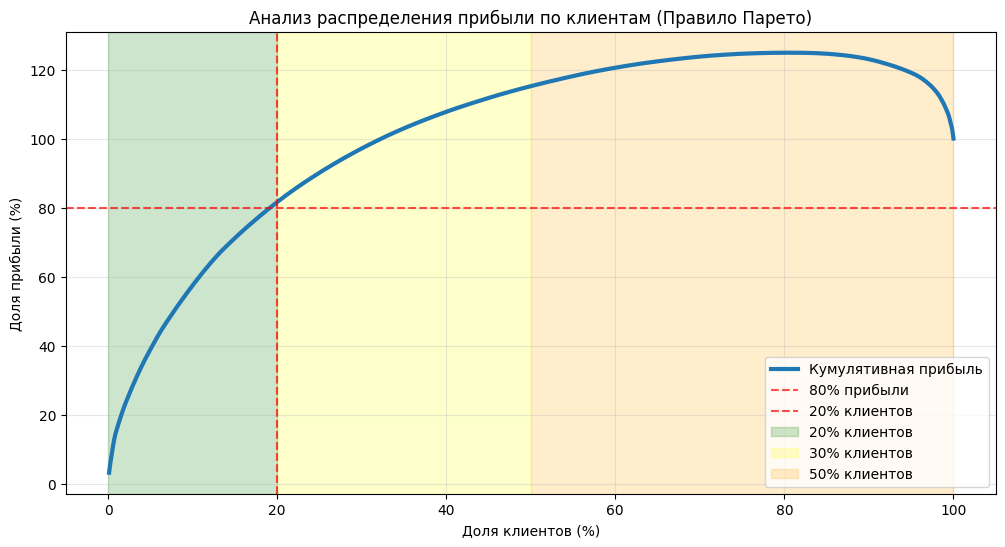

In [59]:
# Визуализация правила Парето для клиентов
plt.figure(figsize=(12, 6))

plt.plot(customer_profit['Customer %'], customer_profit['Cumulative %'], linewidth=3, label='Кумулятивная прибыль')
plt.axhline(y=80, color='red', linestyle='--', alpha=0.7, label='80% прибыли')
plt.axvline(x=20, color='red', linestyle='--', alpha=0.7, label='20% клиентов')

# Области распределения
plt.axvspan(0, 20, alpha=0.2, color='green', label='20% клиентов')
plt.axvspan(20, 50, alpha=0.2, color='yellow', label='30% клиентов')
plt.axvspan(50, 100, alpha=0.2, color='orange', label='50% клиентов')

plt.title('Анализ распределения прибыли по клиентам (Правило Парето)')
plt.xlabel('Доля клиентов (%)')
plt.ylabel('Доля прибыли (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Результат:**

**Гипотеза 3 подтверждена:**
- Правило Парето работает - 20% клиентов приносят 81% прибыли.
- 50% клиентов не просто малоприбыльны - они работают в убыток (-15% прибыли)
- Средние 30% клиентов компенсируют эти убытки, принося 34% прибыли

**Рекомендации:**
- Для топ-20% клиентов: Внедрить систему VIP-обслуживания с персональными менеджерами
- Для убыточных 50% клиентов: необходима срочная оптимизация работы с этим сегментом - перевести на автоматизированное обслуживание, ограничить скидки, минимизировать издержки
- Для средних 30% клиентов: Разработать программу перехода в топ-сегмент через увеличение среднего чека

## **5. Заключение**

Проведенный анализ выявил системные проблемы в управлении скидками и ассортиментом сети супермаркетов "SuperStore".

**Основные драйверы убытков:**
1. Чрезмерно высокие скидки (30%+)
2. Низкорентабельные категории товаров (мебель, особенно столы)
3. Большая доля низкомаржинальных клиентов

**Потенциал роста:**
1. Оптимизация скидочной политики может значительно увеличить прибыль
   (за счет устранения убытков от скидок выше 30%)
2. Фокус на топ-20% клиентов способен существенно повысить их пожизненную ценность (LTV)
3. Ребалансировка ассортимента может улучшить общую рентабельность бизнеса

---
*Дата отчета: 16.01.2026*  
*Автор: Францева Юлия*  
*Статус: Готово*